# **EDA - (ANALISIS EXPLORATORIO DE LOS DATOS)**

En este notebook encontrarás el Análisis exploratorio de datos referente a nuestro proyecto. Para llevar a cabo un análisis de mercado decidimos limitar los Datasets a los Estados de: Wisconsin, New York y California.



### **Configuraciones Globales e Importaciones**
En esta sección, se instalan e importan todas las librerías y/o módulos necesarios para el proceso ETL (Extract, Transform, Load) y se establecen configuraciones globales de ser requerido. Se utilizan las siguientes librerías y herramientas:

In [2]:
#Se conecta Google Colaboratory con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Instalamos SPARK para manejar grande volumnes de datos

In [3]:
#Instala pyspark en Google Colaboratory
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=b510e364d11201f6e4299e35dc24cb213a8f5e49b5737f7372c8116e8244199c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
#Se importan las librerias
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import re
import os # Proporciona funciones para interactuar con el sistema operativo.
import requests # Se utiliza para realizar solicitudes HTTP.
import pandas as pd # Una librería de análisis de datos.
import matplotlib.pyplot as plt
import seaborn as sns #S e utiliza para la visualización de datos.
import pyspark.pandas as ps # Proporciona una interfaz para trabajar con datos en Spark utilizando el formato de DataFrame de pandas.
import json # Se utiliza para trabajar con datos en formato JSON.
from pyspark.sql import SparkSession # Se utiliza para crear una instancia de SparkSession, que es la entrada principal para trabajar con Spark SQL.
from pyspark.sql import functions as F #  Proporciona funciones para trabajar con datos en Spark DataFrame.
from pyspark.sql.functions import array_contains # Esta función se utiliza para filtrar los datos basados en la presencia de un valor en un array.
from pyspark.sql.functions import sum, col # Se utiliza para acceder a una columna en un DataFrame de Spark.
from pyspark.sql.functions import split, substring, concat_ws, max, min, to_date
from pyspark.sql.functions import expr, regexp_replace, when
from pyspark.sql.types import StringType

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("EDA-exhaustivo")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
spark

## **RUTA DE LOS ARCHIVOS**

### **DATASET: GOOGLE MAPS**

In [7]:
# Ruta a la carpeta que contiene los archivos CSV en Google Drive
carpeta = '/content/drive/MyDrive/Colab-Notebooks/transformaciones/meta-final.csv'

# Listar archivos en la carpeta
archivos = os.listdir(carpeta)

# Crear una lista para almacenar los DataFrames
df_list = []

# Iterar sobre los archivos y cargar cada archivo CSV en un DataFrame
for archivo_name in archivos:
    if archivo_name.endswith('.csv'):
        archivo_path = os.path.join(carpeta, archivo_name)
        df = spark.read.csv(archivo_path, header=True)
        # Convertir la columna "MISC" a tipo String si es necesario
        if 'MISC' in df.columns:
            df = df.withColumn("MISC", col("MISC").cast("string"))
        df_list.append(df)

# Unir los DataFrames en uno solo
df_metadata = df_list[0]
for dataframe in df_list[1:]:
    df_metadata = df_metadata.unionByName(dataframe)

In [8]:
# Convertir el DataFrame de Spark a pandas DataFrame
df_metadata = df_metadata.toPandas()

In [9]:
# Ruta a la carpeta que contiene los archivos CSV en Google Drive
carpeta = '/content/drive/MyDrive/Colab-Notebooks/transformaciones/estados-limpios9.csv'

# Listar archivos en la carpeta
archivos = os.listdir(carpeta)

# Crear una lista para almacenar los DataFrames
df_list = []

# Iterar sobre los archivos y cargar cada archivo CSV en un DataFrame
for archivo_name in archivos:
    if archivo_name.endswith('.csv'):
        archivo_path = os.path.join(carpeta, archivo_name)
        df = spark.read.csv(archivo_path, header=True)
        # Convertir la columna "MISC" a tipo String si es necesario
        if 'MISC' in df.columns:
            df = df.withColumn("MISC", col("MISC").cast("string"))
        df_list.append(df)

# Unir los DataFrames en uno solo
df_Reviews_estados = df_list[0]
for dataframe in df_list[1:]:
    df_Reviews_estados = df_Reviews_estados.unionByName(dataframe)

### **DATASET: YELP**

In [10]:
business_yelp = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/transformaciones/bussi-limpio.csv')
checkin_yelp = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/transformaciones/checki-limpio.csv')
tip_yelp = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/transformaciones/tip-limpio.csv')
user_yelp = pd.read_csv('/content/drive/MyDrive/Colab-Notebooks/transformaciones/user-limpio.csv')

In [11]:
# Ruta a la carpeta que contiene los archivos CSV en Google Drive
carpeta = '/content/drive/MyDrive/Colab-Notebooks/Datos-Limpios/review-limpiowsen22.csv'

# Listar archivos en la carpeta
archivos = os.listdir(carpeta)

# Crear una lista para almacenar los DataFrames
df_list = []

# Iterar sobre los archivos y cargar cada archivo CSV en un DataFrame
for archivo_name in archivos:
    if archivo_name.endswith('.csv'):
        archivo_path = os.path.join(carpeta, archivo_name)
        df = spark.read.csv(archivo_path, header=True)
        # Convertir la columna "MISC" a tipo String si es necesario
        if 'MISC' in df.columns:
            df = df.withColumn("MISC", col("MISC").cast("string"))
        df_list.append(df)

# Unir los DataFrames en uno solo
df_Reviews_yelp = df_list[0]
for dataframe in df_list[1:]:
    df_Reviews_yelp = df_Reviews_yelp.unionByName(dataframe)

## #Esta función calcula el porcentaje de valores nulos que tiene cada columna de un determinado dataframe

In [12]:
# Cuenta el número de nulos en cada columna

def conteo_nulos(dataframe):
    # Construye expresiones de agregación para contar nulos en cada columna
    expresiones_agregacion = [sum(col(c).isNull().cast("int")).alias(c) for c in dataframe.columns]

    # Aplica las expresiones de agregación al dataframe
    conteo_nulos_por_columna = dataframe.agg(*expresiones_agregacion)

    # Muestra el resultado
    conteo_nulos_por_columna.show()

In [13]:
def contar_nulos(dataframe):

    # Obtener la cantidad de valores nulos por columna
  nulos_por_columna = dataframe.isnull().sum()

  print("Cantidad de valores nulos por columna:\n", nulos_por_columna)

## **VERIFICAMOS DATOS NULOS**

In [14]:
contar_nulos(df_metadata)

Cantidad de valores nulos por columna:
 address           0
avg_rating        0
category          0
gmap_id           0
latitude          0
longitude         0
name              0
num_of_reviews    0
url               0
state             0
city              0
dtype: int64


In [15]:
conteo_nulos(df_Reviews_estados)

+-------+----+------+----+-------+----+---------+
|gmap_id|name|rating|text|user_id|date|sentiment|
+-------+----+------+----+-------+----+---------+
|      0|  12|    12|  12|     24|  24|       24|
+-------+----+------+----+-------+----+---------+



In [16]:
contar_nulos(business_yelp)

Cantidad de valores nulos por columna:
 Unnamed: 0      0
business_id     0
name            0
address         5
city            0
state           0
latitude        0
longitude       0
stars           0
review_count    0
attributes      0
categories      0
hours           0
dtype: int64


In [17]:
contar_nulos(checkin_yelp)

Cantidad de valores nulos por columna:
 business_id    0
date           0
dtype: int64


In [18]:
contar_nulos(tip_yelp)

Cantidad de valores nulos por columna:
 Unnamed: 0          0
user_id             0
business_id         0
text                9
date                0
compliment_count    0
dtype: int64


In [19]:
contar_nulos(user_yelp)

Cantidad de valores nulos por columna:
 user_id                 0
name                  588
review_count            0
useful                  0
funny                   0
cool                    0
friends                 0
fans                    0
average_stars           0
compliment_hot          0
compliment_more         0
compliment_profile      0
compliment_cute         0
compliment_list         0
compliment_note         0
compliment_plain        0
compliment_cool         0
compliment_funny        0
compliment_writer       0
compliment_photos       0
dtype: int64


In [20]:
conteo_nulos(df_Reviews_yelp)

+---------+-------+-----------+-------+-------+-------+-------+-------+---------+
|review_id|user_id|business_id| review| rating|   cool| useful|  funny|sentiment|
+---------+-------+-----------+-------+-------+-------+-------+-------+---------+
|        0|5043310|    5043310|5043310|7458723|7458723|9874136|9874136|  9874136|
+---------+-------+-----------+-------+-------+-------+-------+-------+---------+



Notamos que por mas de haber eliminados los _DATOS NULOS_ en el _ETL_ todavia tenemos algunos en nuestro dataframe, es por esto que procederemos a eliminar aquellos que no son importante en nuestro analisis.  

In [21]:
# Eliminar filas donde 'name' está vacío
df_Reviews_estados = df_Reviews_estados.dropna(subset=['name'])

In [22]:
# Eliminar filas donde 'user_id' está vacío
df_Reviews_estados = df_Reviews_estados.dropna(subset=['user_id'])

In [23]:
#Eliminamos los NULOS en 'address'
business_yelp = business_yelp.dropna(subset=['address'])

In [24]:
#Eliminamos los NULOS en 'text'
tip_yelp = tip_yelp.dropna(subset=['text'])

In [25]:
#Eliminamos los NULOS en 'name'
user_yelp = user_yelp.dropna(subset=['name'])

In [26]:
# Eliminar filas donde 'user_id' está vacío
df_Reviews_yelp = df_Reviews_yelp.dropna(subset=['user_id'])


In [27]:
# Eliminar filas donde 'cool' está vacío
df_Reviews_yelp = df_Reviews_yelp.dropna(subset=['cool'])


In [28]:
# Eliminar filas donde 'useful' está vacío
df_Reviews_yelp = df_Reviews_yelp.dropna(subset=['useful'])

# **OUTLIERS**

Vamos a estudiar el intervalo de tiempo en el que transcurren las reseñas para ver si ocurre alguna inconsistencia.

In [29]:
# Encuentra el valor máximo y mínimo de 'date'
valor_maximo = df_Reviews_estados.select(max("date")).first()[0]
valor_minimo = df_Reviews_estados.select(min("date")).first()[0]

print(f'El último año es: {valor_maximo}')
print(f'El primer año es: {valor_minimo}')

El último año es: 2021-09-09
El primer año es: 1990-12-31


Hay reseñas desde 1990 hasta 2021 por parte de Google Maps, esto no puede ocurrir porque Google Maps existe desde 2005. Estos datos desde 1990 hasta 2005 ya se catalogan como resultados inesperados.

### Google compró esta compañía en octubre de 2004 para crear el popular software gratuito, basado en el navegador, Google Maps. Google Maps fue anunciado por primera vez en Google Blog el 8 de febrero de 2005.

In [31]:
from pyspark.sql.functions import year, col, max, min

# Definir fecha máxima como una fecha específica
fecha_maxima = '2022-12-31'

# Filtrar el DataFrame por el año >= 2005 y <= fecha_maxima
df_filtrado = df_Reviews_estados.filter((year('date') >= 2005) & (col('date') <= fecha_maxima))

# Encuentra el valor máximo y mínimo de 'date' en el DataFrame filtrado
valor_maximo = df_filtrado.select(max("date")).first()[0]
valor_minimo = df_filtrado.select(min("date")).first()[0]

print(f'El último año en 2005 es: {valor_maximo}')
print(f'El primer año en 2005 es: {valor_minimo}')



El último año en 2005 es: 2021-09-09
El primer año en 2005 es: 2005-01-01


### **Nuestros restaurantes pueden pertenecer a diferentes categorías**, las cuales pueden ser muy variadas, hagamos un conteo del total de categorías que se encuentran en los datos.

In [32]:
# Crea una lista de todas las categorías de business_yelp
categories_yelp = business_yelp['categories'].str.split(',').explode().str.strip().unique()

# Crea una lista de todas las categorías de df_metadata
categories_metadata = df_metadata['category'].str.split(',').explode().str.strip().unique()

# Une ambas listas y obtiene las categorías únicas
all_categories = pd.Series(list(categories_yelp) + list(categories_metadata)).unique()

print(f"Hay {len(all_categories)} categorías")

Hay 4265 categorías


Ahora vamos a encontrar las ciudades con mayor número de restaurantes, esto nos permitirá delimitar el análisis de mercado a las principales ciudades y zonas comerciales.

In [33]:
# Cuenta el número de negocios por ciudad en business_yelp
city_counts_yelp = business_yelp['city'].str.strip().value_counts()

# Cuenta el número de negocios por ciudad en df_metadata
city_counts_metadata = df_metadata['city'].str.strip().value_counts()

# Suma el número de negocios por ciudad de ambos DataFrames
combined_city_counts = city_counts_yelp.add(city_counts_metadata, fill_value=0)

# Obtiene las 10 ciudades con más negocios y las ordena
top_10_cities = combined_city_counts.sort_values(ascending=False).head(10)

# Imprime el resultado
print("Las 10 ciudades con más restaurantes son:")
print(top_10_cities)

Las 10 ciudades con más restaurantes son:
New York         20753.0
Los Angeles      17175.0
Brooklyn         16804.0
San Diego        10746.0
San Francisco     8407.0
Bronx             6693.0
Sacramento        5777.0
San Jose          5345.0
Queens            4460.0
Fresno            4353.0
Name: city, dtype: float64


Acá podemos ver en el **_TOP ten_** pertenecen principalmente a los estados de Nueva York y California.

In [34]:
#Observamos que tenemos dentro del archivo
business_yelp.head()

,Unnamed: 0,business_id,name,address,city,state,latitude,longitude,stars,review_count,attributes,categories,hours
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,29,sqSqqLy0sN8n2IZrAbzidQ,Domino's Pizza,3001 Highway 31 W,White House,CA,36.464747,-86.659187,3.5,8,{'RestaurantsPriceRange2': '1'},"Pizza, Chicken Wings, Sandwiches, Restaurants","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."
2,88,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,114 N 3rd St,Camden,CA,39.946690,-75.123327,4.5,6,"{'BusinessParking': ""{'garage': False, 'street...","Juice Bars & Smoothies, Restaurants, Fruits & ...","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
3,222,8c0r7olQSYGcws0bTd3ikw,Zesty Tsunami,6614 Osteen Rd,New Port Richey,CA,28.250218,-82.682441,4.0,5,"{'RestaurantsReservations': 'False', 'Restaura...","Hawaiian, Food, Food Trucks, Street Vendors, R...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
4,409,QWqKTWQ2OiDgo3dzNkpung,Jong Ka Jib,6600 N 5th St,Philadelphia,CA,40.052064,-75.127394,4.5,351,"{'Alcohol': ""u'none'"", 'RestaurantsGoodForGrou...","Korean, Restaurants","{'Monday': '10:30-22:30', 'Tuesday': '10:30-22..."


También es interesante conocer qué categorías de restaurantes tienen más negocio dentro de los tres Estados.

In [35]:
# Filtrar los restaurantes en los tres estados
restaurantes_estados = business_yelp[business_yelp['state'].isin(['WI', 'NY', 'CA'])]

# Filtrar los restaurantes
restaurantes_filtrados = restaurantes_estados[restaurantes_estados['categories'].str.contains('Restaurant', case=False)]

# Obtener solo las categorías de los restaurantes filtrados
all_categories_series = restaurantes_filtrados['categories']

# Dividir las listas de categorías y convertirlas en una Serie
all_categories_series = all_categories_series.str.split(',').explode().str.strip()

# Contar la frecuencia de cada categoría
category_counts = all_categories_series.value_counts()

# Obtener el top 10 de categorías más comunes
top_10_categories = category_counts.head(10)

# Imprimir el resultado
print("Top 10 categorías de restaurantes más comunes en WI, NY, y CA:")
print(top_10_categories)


Top 10 categorías de restaurantes más comunes en WI, NY, y CA:
Restaurants               1547
Food                       465
Sandwiches                 294
American (Traditional)     262
Nightlife                  244
Bars                       232
Pizza                      229
American (New)             191
Breakfast & Brunch         189
Fast Food                  186
Name: categories, dtype: int64


En este caso nos quedamos con las categorías que no son 'obvias': Fast food restaurant, Pizza restaurant, Nightlife, Sandwiches, American, Bars.

Es importante explorar el rango que tiene el número de reseñas, esto con la finalidad de descartar posibles outlier. Como se verá a continuación el restaurante con más reseñas tiene 7671 lo cual es totalmente posible.

In [36]:
# Encuentra el valor máximo y mínimo de 'num_of_reviews'
valor_maximo = df_metadata['num_of_reviews'].max()
valor_minimo = df_metadata['num_of_reviews'].min()

print(f'El mayor número de reseñas en google es: {valor_maximo}')
print(f'El menor número de reseñas en google es: {valor_minimo}')


El mayor número de reseñas en google es: 9998
El menor número de reseñas en google es: 1


In [37]:
# Encuentra el valor máximo y mínimo de 'review_count'
valor_maximo = business_yelp['review_count'].max()
valor_minimo = business_yelp['review_count'].min()

print(f'El mayor número de reseñas en Yelp es: {valor_maximo}')
print(f'El menor número de reseñas en Yelp es: {valor_minimo}')



El mayor número de reseñas en Yelp es: 2406
El menor número de reseñas en Yelp es: 5


## **Distribución de ratings y reviews:**

In [38]:
# Suponiendo que `df_Reviews_estados` es tu DataFrame de Spark
# Primero, selecciona las columnas que necesitas
selected_columns = ['gmap_id', 'name', 'rating', 'text', 'user_id', 'date', 'sentiment']
df_Reviews_estados_selected = df_Reviews_estados.select(selected_columns)

# Limita la cantidad de filas a recopilar
df_Reviews_estados_selected_limited = df_Reviews_estados_selected.limit(10000)  # Cambia 10000 por el número deseado

# Convierte el DataFrame de Spark a un DataFrame de pandas
df_Reviews_estados_pandas = df_Reviews_estados_selected_limited.toPandas()

### Distribución de ratings:

In [39]:
# Establecer un estilo
sns.set_style("whitegrid")

<Figure size 1200x600 with 0 Axes>

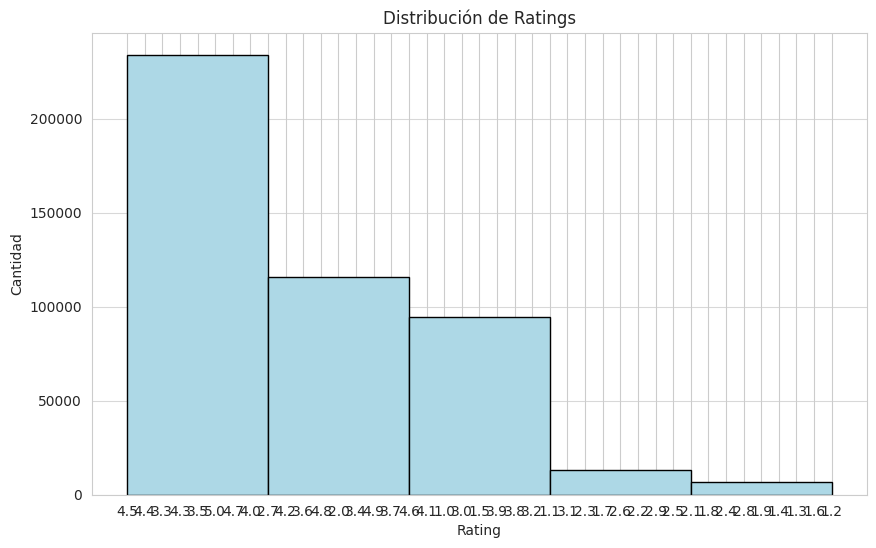

In [40]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Histograma de ratings
plt.figure(figsize=(10, 6))
plt.hist(df_metadata['avg_rating'], bins=5, color='lightblue', edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Cantidad')
plt.title('Distribución de Ratings')
plt.grid(axis='y', alpha=0.75)
plt.show()


### Cantidad de reviews:

<Figure size 1200x600 with 0 Axes>

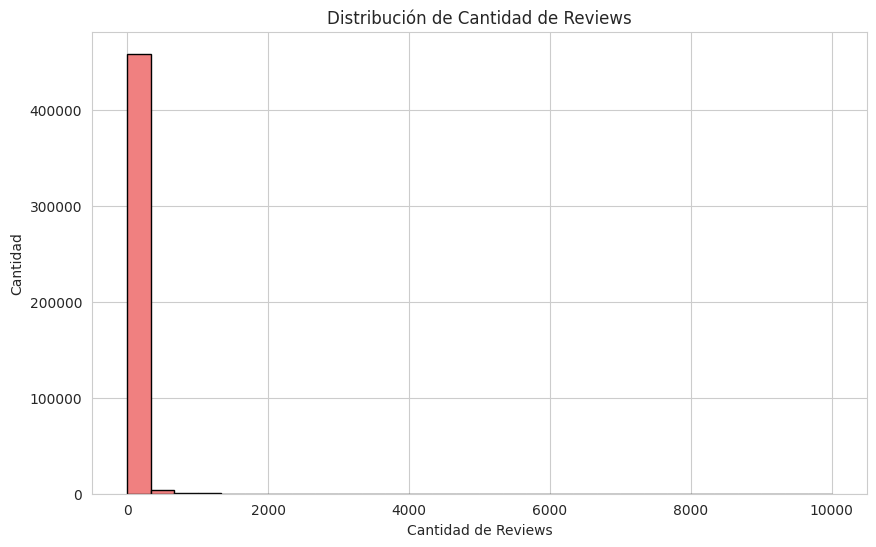

In [41]:
# Convertir la columna num_of_reviews a tipo int
df_metadata['num_of_reviews'] = df_metadata['num_of_reviews'].astype(int)

# Obtener el top 10 de la cantidad de reviews
top_reviews = df_metadata['num_of_reviews'].nlargest(10)

# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Histograma de cantidad de reviews
plt.figure(figsize=(10, 6))
plt.hist(df_metadata['num_of_reviews'], bins=30, color='lightcoral', edgecolor='black')
plt.xlabel('Cantidad de Reviews')
plt.ylabel('Cantidad')
plt.title('Distribución de Cantidad de Reviews')
plt.show()

# **ANÁLISIS GRÁFICO**

Ahora vamos a tratar de visualizar tendencias y a interpretar gráficos, empezamos con dos histogramas que nos representan el progreso temporal que tuvieron las reseñas a través de los años en cada plataforma.

In [42]:
# Creo una lista de los años en los que se hacen reseñas
all_years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


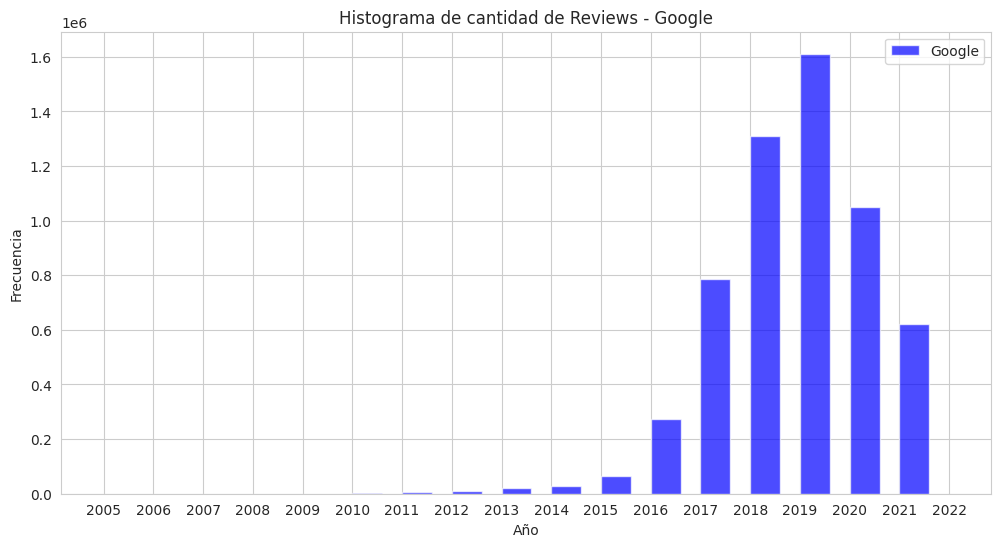

In [43]:
# Extraer el año de la columna 'date' y crear una nueva columna 'year'
df_Reviews_estados = df_Reviews_estados.withColumn('year', year('date'))

# Obtener los años únicos como una lista de Python
all_years_list = df_Reviews_estados.select('year').distinct().rdd.flatMap(lambda x: x).collect()

# Convertir la lista de años a un array de NumPy
all_years_np = np.array(all_years_list)

# Histograma para Google
plt.figure(figsize=(12, 6))
plt.hist(df_Reviews_estados.select('year').rdd.flatMap(lambda x: x).collect(), bins=all_years, color='blue', alpha=0.7, label='Google', width=0.6, align='mid')
plt.xlabel('Año')
plt.xticks(all_years, fontsize=10)
plt.ylabel('Frecuencia')
plt.title('Histograma de cantidad de Reviews - Google')
plt.legend()
plt.show()


Como se puede observar hay un fuerte crecimiento en las reseñas, entre los años 2015 y 2019; desde el 2020 hay una tendencia a la baja debido a la pandemia y las consecuencias de la cuarentena preventiva.

In [44]:
# Elimino los espacios laterales de las cadenas de texto en la columna 'city'
business_yelp['city'] = business_yelp['city'].str.strip()

df_metadata['city'] = df_metadata['city'].str.strip()

Como dije anteriormente, es mejor enfocarnos en las tres ciudades con mayor número de restaurante, ya que esto indica una economía dinámica y zonas comerciales atractivas. Esto ya entra en una etapa de 'pre-análisis de mercado', donde veremos que con los datos que tenemos podemos detectar patrones interesantes.

A continuación se realizarán mapas de calor de la presencia de restaurantes en las tres ciudades elegidas.

In [45]:
#Muestro cuantos restaurantes de CALIFORNIA hay en el Dataset business_yelp

business_yelp[business_yelp['state']=='CA'].head(5)

,Unnamed: 0,business_id,name,address,city,state,latitude,longitude,stars,review_count,attributes,categories,hours
0,3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,29,sqSqqLy0sN8n2IZrAbzidQ,Domino's Pizza,3001 Highway 31 W,White House,CA,36.464747,-86.659187,3.5,8,{'RestaurantsPriceRange2': '1'},"Pizza, Chicken Wings, Sandwiches, Restaurants","{'Monday': '10:0-0:0', 'Tuesday': '10:0-0:0', ..."
2,88,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,114 N 3rd St,Camden,CA,39.946690,-75.123327,4.5,6,"{'BusinessParking': ""{'garage': False, 'street...","Juice Bars & Smoothies, Restaurants, Fruits & ...","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
3,222,8c0r7olQSYGcws0bTd3ikw,Zesty Tsunami,6614 Osteen Rd,New Port Richey,CA,28.250218,-82.682441,4.0,5,"{'RestaurantsReservations': 'False', 'Restaura...","Hawaiian, Food, Food Trucks, Street Vendors, R...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
4,409,QWqKTWQ2OiDgo3dzNkpung,Jong Ka Jib,6600 N 5th St,Philadelphia,CA,40.052064,-75.127394,4.5,351,"{'Alcohol': ""u'none'"", 'RestaurantsGoodForGrou...","Korean, Restaurants","{'Monday': '10:30-22:30', 'Tuesday': '10:30-22..."


In [46]:
#Creo un dataframe para Cali

Cali_sitios=df_metadata[df_metadata['state']=='CA']

In [47]:
# Crea un mapa interactivo centrado en california con la librería folium
cali_map = folium.Map(location=[36.7783, -119.4179], zoom_start=6, control_scale=True)


# Crea un mapa de calor y lo agrega al mapa de Miami
heat_data = [[point.latitude, point.longitude] for point in Cali_sitios.itertuples()]
HeatMap(heat_data).add_to(cali_map)

#Visualiza el mapa
cali_map

Output hidden; open in https://colab.research.google.com to view.

In [48]:
# Crea un mapa interactivo centrado en New York con la librería folium
Ny_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10, control_scale=True)

# Crea un mapa de calor y lo agrega al mapa de Miami
heat_data = [[point.latitude, point.longitude] for point in Cali_sitios.itertuples()]
HeatMap(heat_data).add_to(Ny_map)

#Visualiza el mapa
Ny_map

Output hidden; open in https://colab.research.google.com to view.

Aquí se puede ver que nuestros datos son bastante coherentes, la zona más caliente  las zonas más turísticas.


In [49]:
print(df_Reviews_estados.columns)

['gmap_id', 'name', 'rating', 'text', 'user_id', 'date', 'sentiment', 'year']


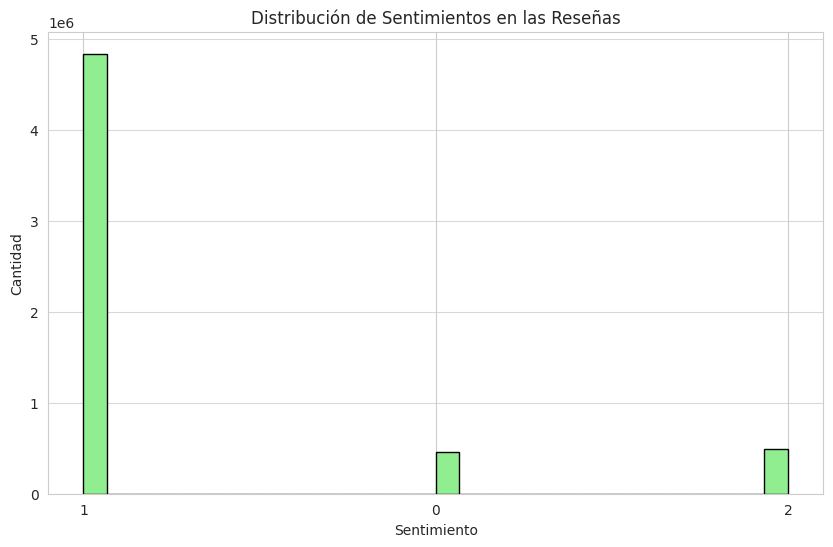

In [50]:
# Convertir la columna de Spark DataFrame a una lista de Python
sentiments = df_Reviews_estados.select('sentiment').rdd.flatMap(lambda x: x).collect()

# Crear el histograma con la lista de sentimientos
plt.figure(figsize=(10, 6))
plt.hist(sentiments, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.title('Distribución de Sentimientos en las Reseñas')
plt.grid(axis='y', alpha=0.75)
plt.show()

